# EECS764P Coursework 4
- Name: Bheki Maenetja
- Student ID: 230382466

## Imports

In [1]:
# !pip install plotly
# !pip install pandas-datareader

import numpy as np

from scipy.stats import linregress, kstest, norm
# from scipy.optimize import minimize
import pandas_datareader.data as web
from pandas_datareader import wb

from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
# pio.renderers.default = "iframe"

## Plotting Functions

In [2]:
# Plotting functions
def plot_data(x=None, y=None, z=None, size=None, colour=None, title="", colour_title="", x_label="", y_label="", name="", mode="markers", text="", fill=None, **traces):
    """
    General purpose function for plotting scatter plots in plotly.
    """
    fig = go.Figure(layout={
        "title": title,
        "xaxis": {"title": x_label},
        "yaxis": {"title": y_label}
    })

    marker = dict()
    
    if size is not None:
        marker["size"] = size
        marker["sizeref"] = 0.01
    if colour is not None:
        marker["color"] = colour
        marker["showscale"] = True
        marker["colorbar"] = dict(title=colour_title)
    
    if z is None:
        data = go.Scatter(
            x=x,
            y=y,
            mode=mode,
            name=name,
            text=text,
            fill=fill,
            marker=marker,
        )
    else:
        data = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode=mode,
            name=name,
            text=text,
            marker=marker,
        )

    if x is not None and y is not None:
        fig.add_trace(data)
    
    for t in traces:
        fig.add_trace(traces[t])
    
    return fig

def create_trace(x=None, y=None, z=None, size=None, colour=None, colour_title="", name="", mode="lines", text="", fill=None):
    marker = dict()
    
    if size is not None:
        marker["size"] = size
        marker["sizeref"] = 0.01
    if colour is not None:
        marker["color"] = colour
        marker["showscale"] = True
        marker["colorbar"] = dict(title=colour_title)
    
    if z is None:
        trace = go.Scatter(
            x=x,
            y=y,
            mode=mode,
            name=name,
            text=text,
            fill=fill,
            marker=marker
        )
    else:
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode=mode,
            name=name,
            text=text,
            marker=marker
        )
    
    return trace

def create_histogram(x=None, y=None, histnorm="", name=""):
    return go.Histogram(
        x=x,
        y=None,
        histnorm=histnorm,
        name=name,
    )

def create_candle_stick(x=None, open=None, close=None, high=None, low=None, name=""):
    return go.Candlestick(
        x=x,
        open=open,
        close=close,
        high=high,
        low=low,
        name=name,
    )

def plot_collection(plots, rows=1, cols=1, title="", subplot_titles=[], x_labels={}, y_labels={}, height=1000):
    specs = [
        [{"type": "xy"} for c in range(cols)] 
        for r in range(rows)
    ]
    
    fig = make_subplots(
        rows=rows, 
        cols=cols, 
        subplot_titles=subplot_titles,
        specs=specs,
    )
    
    fig.update_layout({
        "title": title,
        "height": height,
    })

    # Add traces
    for k in plots:
        for i in range(len(plots[k].data)):
            fig.add_trace(plots[k].data[i], row=k[0], col=k[1])

    # Update axes
    for k in plots:
        fig.update_xaxes(title_text=x_labels.get(k, ""), row=k[0], col=k[1])
        fig.update_yaxes(title_text=y_labels.get(k, ""), row=k[0], col=k[1])

    return fig

## Question 1

### Loading Data

/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: WLD
  warnings.warn(


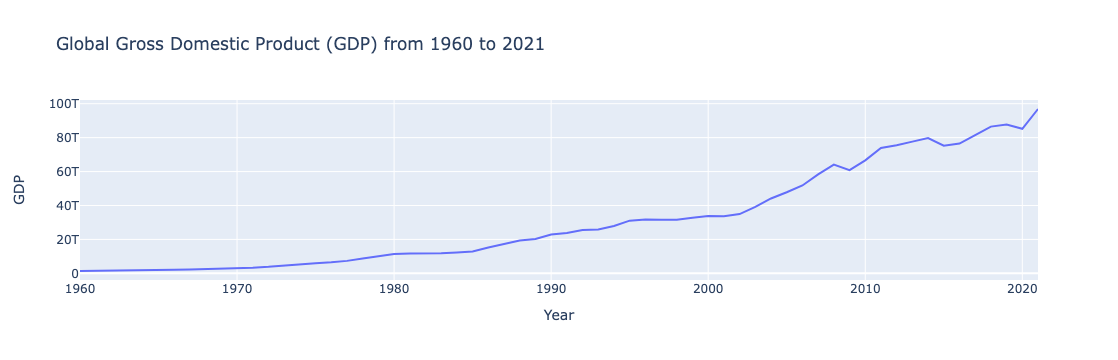

In [3]:
gdp_data = wb.download(indicator="NY.GDP.MKTP.CD", country="WLD", start="1960" , end="2021")
time = np.arange(1960,2022)
gdp = gdp_data.iloc[:,0].astype(float).to_numpy()
# Data is returned in inverse chronological order , so reverse order
gdp = np.flip(gdp)
plot_data(
    time,
    gdp,
    title="Global Gross Domestic Product (GDP) from 1960 to 2021",
    x_label="Year",
    y_label="GDP",
    mode="lines",
)

### Applying Transformation to GDP Data 
We can transform the relationship between time and GDP into a linear relationship by taking the logarithm of both sides of the equation. This transformation turns the multiplicative relationship into an additive one, which can be represented as a straight line in a linear regression model.

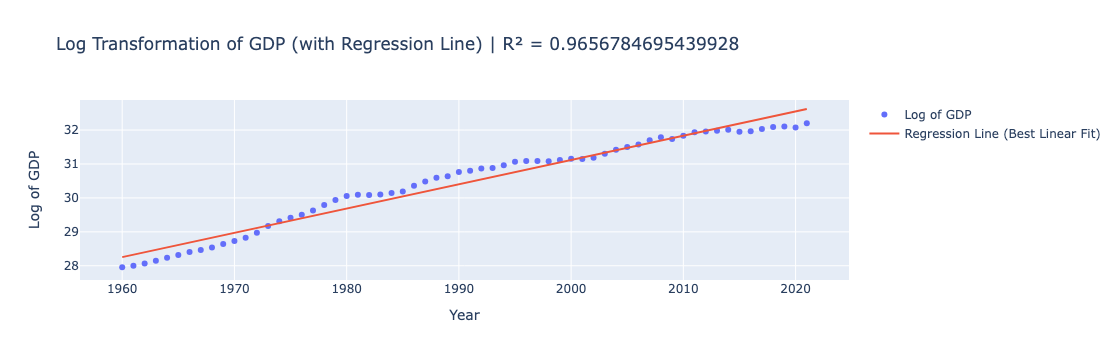

In [4]:
# Apply logarithm transformation to GDP
gdp_log = np.log(gdp)

# Fit linear model
params = linregress(time, gdp_log)

# Get learnt parameters from model
slope = params.slope
intercept = params.intercept
r2 = params.rvalue ** 2

# Calculate regression line
reg_line = slope * time + intercept

# Plot results
reg_line_trace = create_trace(time, reg_line, name="Regression Line (Best Linear Fit)")
gdp_log_trace = create_trace(time, gdp_log, name="Log of GDP", mode="markers")

plot_data(
    t1=gdp_log_trace,
    t2=reg_line_trace,
    x_label="Year",
    y_label="Log of GDP",
    title=f"Log Transformation of GDP (with Regression Line) | R\u00b2 = {r2}"
)

### Calculating Residuals and Performing KS-Test

In [5]:
# Calculate residuals
res = gdp_log - reg_line

# Calculate mean and standard deviation of residuals
res_mean = np.mean(res)
res_std = np.std(res)

# Perform KS-test against a normal distribution with mean 0 and standard deviation of the residuals
_, p_val = kstest(res, "norm", args=(0, res_std))

alpha = 0.99 # (99% confidence)
reject_null = p_val < (1-alpha)

print(f"Alpha = {alpha}\nP-value = {p_val}", end="\n\n")
if reject_null:
    print("We can reject the null hypothesis.")
else:
    print("We cannot reject the null hypothesis.")

Alpha = 0.99
P-value = 0.2211569155807661

We cannot reject the null hypothesis.


### Applying Inverse of Transformation to Linear Model

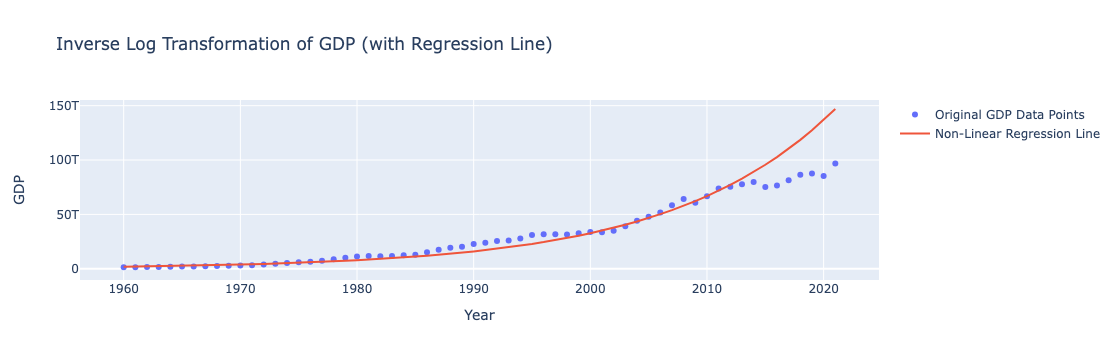

In [6]:
# Apply inverse of the log transformation (exponentiation) to regression line
nonlin_reg_line = np.exp(reg_line)

# Plot results
nonlin_reg_line_trace = create_trace(time, nonlin_reg_line, name="Non-Linear Regression Line")
gdp_trace = create_trace(time, gdp, name="Original GDP Data Points", mode="markers")

plot_data(
    t1=gdp_trace,
    t2=nonlin_reg_line_trace,
    x_label="Year",
    y_label="GDP",
    title=f"Inverse Log Transformation of GDP (with Regression Line)"
)

### Annual Growth Rate of World GDP

The relationship between the slope of the regression line on the logarithmically transformed GDP data and the long-term growth rate is almost a directly proportional relationship. Specifically, the slope of the linear regression of the log-transformed GDP data is an estimate of the continuous, long-term growth rate of global GDP.

In [7]:
# Calculating long-term growth rate
rate = (np.exp(slope) - 1) * 100
print(f"Long-term growth rate = {rate}%")

Long-term growth rate = 7.418942390303673%


### The Post-2014 Slowdown

When looking at the charts for both the log and inverse transformations we observe that, from around 2015 onwards, the data points appear to deviate well below the regression line. This suggests that the actual GDP growth rate may have been slower than predicted by the trend of the past. This could signify a more long-term economic slowdown or other factors that have caused GDP growth to decrease compared to previous years.

## Question 2

### Generating Error Vectors and Performing Regression

In [8]:
N = 200
x = np.linspace(-5, 5, N)

# Model parameters
a = 1/2
b = 2

slopes = []
intercepts = []

for _ in range(10000):
    # Generate error vector
    e = norm.rvs(0, 0.5, N)

    # Calculate y
    y = a * x + b + e

    # Perform linear regression
    params = linregress(x, y)

    # Collect slopes and intercepts
    slopes.append(params.slope)
    intercepts.append(params.intercept)

### Plotting Histograms of Slopes and Intercepts

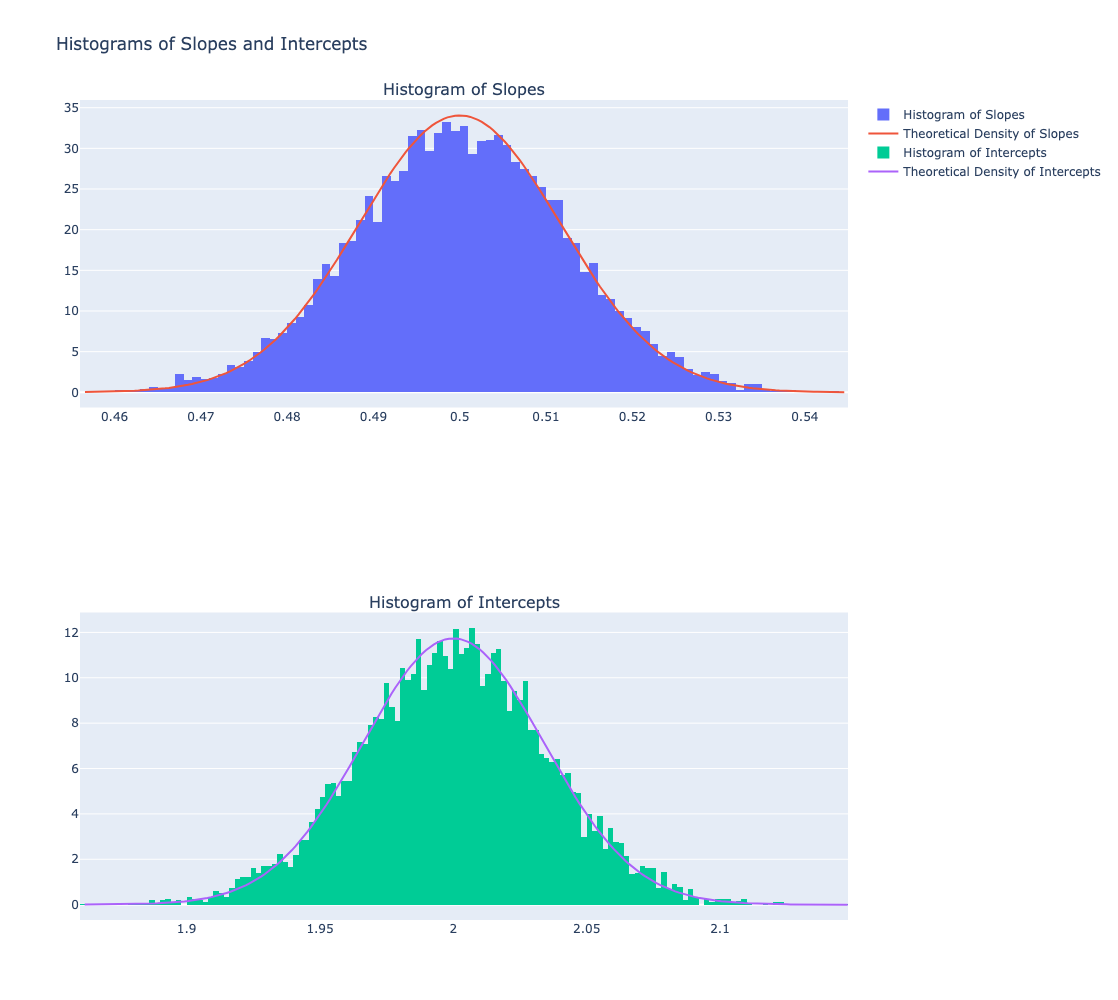

In [9]:
# Creating histograms
slopes_hist = create_histogram(slopes, histnorm="probability density", name="Histogram of Slopes")
inter_hist = create_histogram(intercepts, histnorm="probability density", name="Histogram of Intercepts")

# Creating PDF curves
slope_theory_mean = a
slope_x_vals = np.linspace(min(slopes), max(slopes), N)
slope_theory_std = np.std(e) / np.sqrt(np.sum((x - np.mean(x))**2))
slope_prob_curve = norm.pdf(slope_x_vals, slope_theory_mean, slope_theory_std)

inter_theory_mean = b
inter_x_vals = np.linspace(min(intercepts), max(intercepts), N)
inter_theory_std = np.std(e) / np.sqrt(N)
inter_prob_curve = norm.pdf(inter_x_vals, inter_theory_mean, inter_theory_std)

# Creating probability curves
slope_trace = create_trace(slope_x_vals, slope_prob_curve, name="Theoretical Density of Slopes")
inter_trace = create_trace(inter_x_vals, inter_prob_curve, name="Theoretical Density of Intercepts")

plots = {
    (1,1): plot_data(t1=slopes_hist, t2=slope_trace),
    (2,1): plot_data(t1=inter_hist, t2=inter_trace),
}

plot_collection(
    plots, 
    rows=2, 
    cols=1, 
    title="Histograms of Slopes and Intercepts", 
    subplot_titles=["Histogram of Slopes", "Histogram of Intercepts"], 
    height=1000,
)

The closeness of the histograms to their respective theoretical density curves suggests that the simulated linear regressions have produced parameter estimates that are unbiased and normally distributed around the true parameter values; this is in line with the central limit theorem.

### Test Statistics